In [19]:
# Financial inclusion project
# Name: Immanuella Duke
# Description: This project predicts whether a given person has a bank account or not.
# Link to hackathon: https://zindi.africa/competitions/financial-inclusion-in-africa


## Import libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
import csv

## Data Exploration stage

In [21]:
# import the training data
train_data = pd.read_csv("Train_v2.csv")
#test x
test_X = pd.read_csv("Test_v2.csv")


### Encode column items

In [22]:
# check for correlations in the Data

# encode categorical variables

clean_upX = {'country': {'Rwanda':0, 'Tanzania': 1, 'Kenya':2, 'Uganda': 3},
'location_type': {'Rural':0, 'Urban': 1},
'cellphone_access': {'Yes': 0, 'No': 1},
'gender_of_respondent': {'Female': 0, 'Male': 1},
'relationship_with_head': {'Head of Household': 0, 'Spouse': 1, 'Child': 2, 'Parent': 3, 'Other relative': 4, 'Other non-relatives': 5},
'marital_status': {'Married/Living together': 0, 'Single/Never Married': 1, 'Widowed': 2, 'Divorced/Seperated': 3, 'Dont know': 4},
'education_level': {'Primary education': 0, 'No formal education': 1, 'Secondary education': 2, 
                    'Tertiary education': 3, 'Vocational/Specialised training':4,'Other/Dont know/RTA': 5 },
'job_type': {'Self employed': 0, 'Informally employed': 1, 'Farming and Fishing': 2, 'Remittance Dependent':3, 'Other Income':4,
                     'Formally employed Private': 5, 'No Income': 6, 'Formally employed Government': 7, 'Government Dependent': 8, 'Dont Know/Refuse to answer': 9 },
                     'bank_account': {'Yes': 0, 'No': 1}
}

# replace columns
train_data.replace(clean_upX, inplace=True)
test_X.replace(clean_upX, inplace=True)

In [23]:
# training y
train_Y = train_data['bank_account']
train_Y

0        0
1        1
2        0
3        1
4        1
        ..
23519    1
23520    1
23521    1
23522    1
23523    1
Name: bank_account, Length: 23524, dtype: int64

In [33]:
#training x
train_X = train_data[['country','year', 'location_type', 'cellphone_access', 'household_size',
                    'age_of_respondent' ,'gender_of_respondent', 'relationship_with_head', 'marital_status', 
                    'education_level', 'job_type']]
                    
test_X = test_X[['country','year', 'location_type', 'cellphone_access', 'household_size',
                    'age_of_respondent' ,'gender_of_respondent', 'relationship_with_head', 'marital_status', 
                    'education_level', 'job_type']]

([<matplotlib.axis.YTick at 0x153109c40c8>,
 <a list of 11 Text yticklabel objects>)

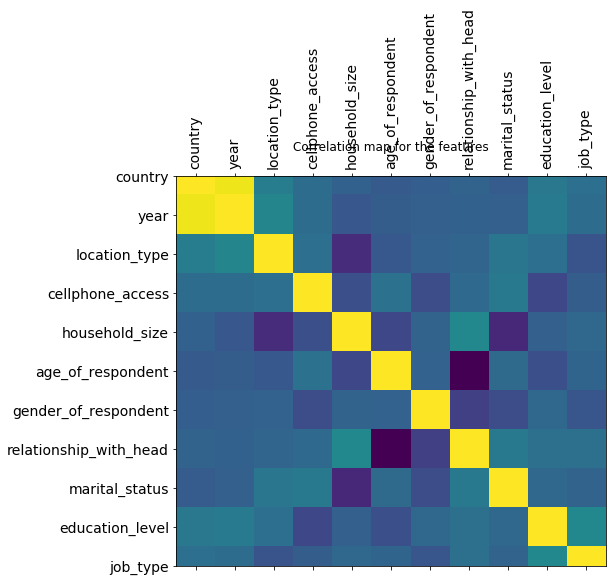

In [34]:
## correlations
train_X.corr()

#heap map of the correlations
f = plt.figure(figsize=(10,7))
plt.matshow(train_X.corr(), fignum= f.number)
plt.title("Correlation map for the features")
plt.xticks(range(train_X.shape[1]), train_X.columns, fontsize=14, rotation=90)
plt.yticks(range(train_X.shape[1]), train_X.columns, fontsize=14)

#### we see a weak positive correlation between education level and a person's country, 
#### location_type and marital status also have a weak positive correlation
#### education level, marital statusage, gender of respondent have weak correlations in the range of 0.1 with cell phone access
#### household size and relationship with head of the household have 0.2 correlation
#### the older the respondent the less of a relationship they have with the head - perhaps children are closer to their parents?
#### 

## Feature Selection

In [35]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [36]:
forward_regression(train_X, train_Y, threshold_in=0.55)

['education_level',
 'cellphone_access',
 'relationship_with_head',
 'job_type',
 'location_type',
 'gender_of_respondent',
 'marital_status',
 'year',
 'country',
 'age_of_respondent',
 'household_size']

#### the forward stepwise regression shows that the following are the best features: 
['education_level',
 'cellphone_access',
 'relationship_with_head',
 'job_type',
 'location_type',
 'gender_of_respondent',
 'marital_status',
 'year',
 'country',
 'age_of_respondent']

## Train models


In [62]:
predict_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [80]:
#logistic regression model
logistic_model = LogisticRegression(random_state=0).fit(train_X, train_Y)

#predicting on the test data
predict_test = logistic_model.predict(test_X)
print("predictions on test: ", predict_test)

#scoring on training data
predict_train = logistic_model.predict(train_X)
print("predictions on train: ", predict_train)
score = logistic_model.score(train_X, train_Y)
print("score: ", score)

predictions on test:  [0 0 1 ... 0 1 1]
predictions on train:  [1 1 1 ... 1 1 1]
score:  0.8798673694949839
TN:  854 FP:  2458 FN:  368 TP:  19844
accuracy:  0.8798673694949839


In [84]:
#using classification accuracy for training data
tn, fp, fn, tp = confusion_matrix(np.array(train_Y), predict_train).ravel()
print("TN: ", tn, "FP: ", fp, "FN: ", fn, "TP: ", tp)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print("accuracy: ", accuracy)

#error metrics
#precision: out of all the positive classes we have predicted, how many are actually positive
print("precision: ", tp/(tp+fp))
#recall: out of all the actual positive classes, how many where predicted correctly
print("recall: ", tp/(tp+fn))

TN:  854 FP:  2458 FN:  368 TP:  19844
accuracy:  0.8798673694949839
precision:  0.8897856694466864
recall:  0.9817929942608351


## Writing results to excel file

In [90]:
test_X1 = pd.read_csv("Test_v2.csv")
unique_ids = test_X1['uniqueid']
year

In [94]:
test_X1.iloc[:3, :]

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent


In [101]:
maker['country']

0    Kenya
1    Kenya
2    Kenya
Name: country, dtype: object

In [102]:
maker = test_X1.iloc[:3, :]
unique_ids = maker['uniqueid']
years = maker['country']

for i in range(len(maker)): 
    print ( unique_ids[i]+ ' x '+ years[i])

uniqueid_6056 x Kenya
uniqueid_6060 x Kenya
uniqueid_6065 x Kenya


In [105]:
#write to excel file


with open('submissions2.csv', mode='w') as csv_file:
    fieldnames = ['uniqueid', 'bank_account']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    unique_ids = test_X1['uniqueid']
    years = test_X1['country']
    count = 0
    for i in range(len(test_X1)): 
        writer.writerow({'uniqueid': unique_ids[i]+ ' x '+ years[i], 'bank_account': predict_test[count]})
        count+=1
    
